In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir("/home/gigag/Documents/job/desafiopaddle")

## Undistorting vid

In [ ]:
def undistort_video(input_path, output_path, calibration_images=None):
    """
    Remove lens distortion from a video file
    
    Parameters:
    - input_path: Path to the input video file
    - output_path: Path to save the undistorted video
    - calibration_images: Optional list of paths to chessboard images for calibration
                         If None, uses default estimation values
    """
    # Use estimated values for a typical wide-angle camera
    # These are default values, adjust based on your specific camera if known
    print("Using default camera parameters (no calibration images provided)")
    # Camera matrix (focal length and optical centers)
    mtx = np.array([
        [1000, 0, 960],  # fx, 0, cx
        [0, 1000, 540],  # 0, fy, cy
        [0, 0, 1]
    ])
    # Distortion coefficients [k1, k2, p1, p2, k3]
    dist = np.array([[-0.3, 0.1, 0, 0, -0.02]])

    # Open the video file
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return False
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate optimal camera matrix
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (width, height), 1, (width, height))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    print(f"Processing video with {frame_count} frames...")
    frame_idx = 0
    
    # Process each frame
    with tqdm(total=frame_count) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Undistort the frame
            dst = cv2.undistort(frame, mtx, dist, None, newcameramtx)
            
            # Crop the image (optional)
            x, y, w, h = roi
            dst = dst[y:y+h, x:x+w]
            
            # Resize back to original dimensions if needed
            if dst.shape[1] != width or dst.shape[0] != height:
                dst = cv2.resize(dst, (width, height))
            
            # Write the undistorted frame
            out.write(dst)
            
            frame_idx += 1
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Undistorted video saved to {output_path}")
    return True

In [ ]:
undistort_video("10secs.mp4", "undist.mp4")

## Rotating to straighten the image

In [3]:
def detect_court_lines_for_alignment(frame):
    """
    Detect main court lines just for alignment purposes
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    
    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Dilate to connect edge components
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Save intermediate results for debugging
    cv2.imwrite("edges_detected.jpg", edges)
    
    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(
        dilated, rho=1, theta=np.pi/180, 
        threshold=100, minLineLength=100, maxLineGap=10
    )
    
    if lines is None or len(lines) < 3:
        print("Not enough lines detected, try lower thresholds")
        return None
    
    # Find horizontal-ish lines (court boundaries)
    h_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate angle and length
        angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        # Group based on angle (horizontal-ish lines)
        if angle < 30 or angle > 150:
            h_lines.append((line[0], length, angle))
    
    # Sort by length to get the most prominent lines
    h_lines.sort(key=lambda x: x[1], reverse=True)
    
    # Get the longest horizontal line for angle calculation
    if h_lines:
        main_line = h_lines[0][0]
        x1, y1, x2, y2 = main_line
        
        # Calculate angle of rotation needed
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if angle > 90:
            angle = angle - 180
        
        # Visualization for debugging
        line_frame = frame.copy()
        cv2.line(line_frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(line_frame, f"Angle: {angle:.2f} degrees", (50, 50), 
                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imwrite("main_alignment_line.jpg", line_frame)
        
        return angle
    else:
        print("No suitable horizontal lines found")
        return None

In [4]:
def align_and_center_video(input_path, output_path):
    """
    Align the court to be level and center it in the frame
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return False
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video dimensions: {width}x{height}, FPS: {fps}")
    
    # Read first frame for court detection
    ret, first_frame = cap.read()
    if not ret:
        print("Failed to read the first frame")
        return False
    
    # Try to detect court angle
    print("Detecting court alignment...")
    angle = detect_court_lines_for_alignment(first_frame)
    
    if angle is None:
        print("Could not detect court angle automatically.")
        # Default to no rotation
        angle = 0
    
    print(f"Detected rotation angle: {angle:.2f} degrees")
    
    # Calculate transformation matrix for rotation
    # Get rotation matrix for the angle
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new dimensions after rotation to avoid cropping
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the new dimensions
    rotation_matrix[0, 2] += (new_width - width) // 2
    rotation_matrix[1, 2] += (new_height - height) // 2
    
    # Apply rotation to the first frame for verification
    rotated_first_frame = cv2.warpAffine(first_frame, rotation_matrix, (new_width, new_height))
    cv2.imwrite("rotated_first_frame.jpg", rotated_first_frame)
    
    # Create video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    # Reset video capture to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    print(f"Processing video with {frame_count} frames...")
    
    # Process each frame
    with tqdm(total=frame_count) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (new_width, new_height))
            
            # Write rotated frame
            out.write(rotated_frame)
            
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Aligned video saved to {output_path}")
    return True


In [5]:
def manual_rotate_and_center(input_path, output_path, angle=0):
    """
    Manually rotate and center the video by a specified angle
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return False
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video dimensions: {width}x{height}, FPS: {fps}")
    
    # Read first frame for preview
    ret, first_frame = cap.read()
    if not ret:
        print("Failed to read the first frame")
        return False
    
    # Calculate transformation matrix for rotation
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new dimensions after rotation to avoid cropping
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the new dimensions
    rotation_matrix[0, 2] += (new_width - width) // 2
    rotation_matrix[1, 2] += (new_height - height) // 2
    
    # Apply rotation to the first frame for verification
    rotated_first_frame = cv2.warpAffine(first_frame, rotation_matrix, (new_width, new_height))
    cv2.imwrite("manual_rotated_preview.jpg", rotated_first_frame)
    
    print(f"Preview saved with {angle} degree rotation. Check 'manual_rotated_preview.jpg'")
    print("If you're satisfied with the rotation, proceed. Otherwise, try a different angle value.")
    
    # Ask for confirmation - you can remove this part if running in a script
    proceed = input("Proceed with processing the whole video? (y/n): ")
    if proceed.lower() != 'y':
        return False
    
    # Create video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    # Reset video capture to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    print(f"Processing video with {frame_count} frames...")
    
    # Process each frame
    with tqdm(total=frame_count) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (new_width, new_height))
            
            # Write rotated frame
            out.write(rotated_frame)
            
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Aligned video saved to {output_path}")
    return True

In [6]:
def simple_rotation_preview(input_path, angles=[-2, -1, 0, 1, 2]):
    """
    Generate preview images with different rotation angles
    """
    # Read the first frame
    cap = cv2.VideoCapture(input_path)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print("Failed to read the first frame")
        return False
    
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    
    for angle in angles:
        # Get rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Calculate new dimensions after rotation to avoid cropping
        abs_cos = abs(rotation_matrix[0, 0])
        abs_sin = abs(rotation_matrix[0, 1])
        new_width = int(height * abs_sin + width * abs_cos)
        new_height = int(height * abs_cos + width * abs_sin)
        
        # Adjust the rotation matrix to take into account the new dimensions
        rotation_matrix[0, 2] += (new_width - width) // 2
        rotation_matrix[1, 2] += (new_height - height) // 2
        
        # Apply rotation to the frame
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (new_width, new_height))
        
        # Add text to indicate the angle
        cv2.putText(rotated_frame, f"Rotation: {angle} degrees", (50, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Save the preview image
        preview_path = f"rotation_preview_{angle}.jpg"
        cv2.imwrite(preview_path, rotated_frame)
        print(f"Saved preview for {angle} degrees rotation to {preview_path}")
    
    print("Generated preview images for different rotation angles.")
    return True

In [7]:
align_and_center_video("undist.mp4", "v3.mp4")

Video dimensions: 1920x1080, FPS: 30.1
Detecting court alignment...
Detected rotation angle: -0.95 degrees
Processing video with 300 frames...


100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 48.31it/s]

Aligned video saved to v3.mp4


True

## Second attempt

In [1]:
def detect_court_alignment_improved(frame):
    """
    Improved method to detect court alignment angle
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    
    # Edge detection with lower threshold to catch more lines
    edges = cv2.Canny(blurred, 40, 120)
    
    # Dilate to connect edge components
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Save intermediate results for debugging
    cv2.imwrite("edges_detected.jpg", edges)
    
    # Detect lines using Hough Lines Transform (not HoughLinesP)
    # This gives us more precise angle measurements
    lines = cv2.HoughLines(dilated, rho=1, theta=np.pi/180, threshold=150)
    
    if lines is None or len(lines) < 5:  # Need multiple lines for consensus
        # Fall back to HoughLinesP if needed
        print("Few lines detected with HoughLines, trying HoughLinesP...")
        lines_p = cv2.HoughLinesP(
            dilated, rho=1, theta=np.pi/180, 
            threshold=80, minLineLength=80, maxLineGap=15
        )
        
        if lines_p is None or len(lines_p) < 3:
            print("Not enough lines detected with either method")
            return None
            
        # Convert HoughLinesP format to angles only
        angles = []
        for line in lines_p:
            x1, y1, x2, y2 = line[0]
            # Only consider relatively horizontal lines
            curr_angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            if abs(curr_angle) < 45 or abs(curr_angle) > 135:
                angles.append(curr_angle)
                
        if not angles:
            print("No suitable horizontal lines found")
            return None
    else:
        # Process HoughLines output (rho, theta format)
        angles = []
        for rho, theta in lines[:, 0]:
            # Convert theta to degrees
            angle_rad = theta
            angle_deg = angle_rad * 180 / np.pi - 90  # -90 to get the actual line angle
            
            # Only consider relatively horizontal lines (near 0 or 180 degrees)
            if abs(angle_deg) < 45 or abs(angle_deg - 180) < 45 or abs(angle_deg + 180) < 45:
                # Normalize angle to -90 to +90 range
                if angle_deg > 90:
                    angle_deg -= 180
                elif angle_deg < -90:
                    angle_deg += 180
                    
                angles.append(angle_deg)
    
    # Create a visualization of all detected lines
    debug_frame = frame.copy()
    
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(debug_frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    cv2.imwrite("all_detected_lines.jpg", debug_frame)
    
    # Use statistical approach to find the consensus angle
    if not angles:
        print("No suitable lines found for angle calculation")
        return None
    
    # Create a histogram of angles to find the most common alignment
    # This is more robust than just taking the average
    hist, bin_edges = np.histogram(angles, bins=36, range=(-45, 45))
    most_common_bin = np.argmax(hist)
    
    # Calculate the average angle within the most common bin
    bin_min = bin_edges[most_common_bin]
    bin_max = bin_edges[most_common_bin + 1]
    filtered_angles = [a for a in angles if bin_min <= a <= bin_max]
    
    # Remove outliers using IQR method for more robustness
    if filtered_angles:
        q1 = np.percentile(filtered_angles, 25)
        q3 = np.percentile(filtered_angles, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        final_angles = [a for a in filtered_angles if lower_bound <= a <= upper_bound]
        
        if not final_angles:
            final_angles = filtered_angles  # Fallback
            
        final_angle = np.median(final_angles)  # Median is more robust than mean
    else:
        final_angle = np.median(angles)  # Fallback
    
    # Create visualization of the chosen angle
    angle_vis_frame = frame.copy()
    h, w = frame.shape[:2]
    center_x, center_y = w // 2, h // 2
    length = max(w, h) // 2
    
    end_x = int(center_x + length * np.cos(final_angle * np.pi / 180))
    end_y = int(center_y + length * np.sin(final_angle * np.pi / 180))
    
    cv2.line(angle_vis_frame, (center_x, center_y), (end_x, end_y), (0, 0, 255), 3)
    cv2.putText(angle_vis_frame, f"Angle: {final_angle:.2f}°", 
              (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    cv2.imwrite("final_alignment_angle.jpg", angle_vis_frame)
    
    return final_angle

In [2]:
def align_court_video_improved(input_path, output_path):
    """
    Align the court video using improved detection method
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return False
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video dimensions: {width}x{height}, FPS: {fps}")
    
    # Process multiple frames for more robust detection
    num_sample_frames = 5
    frame_indices = np.linspace(0, min(frame_count-1, 100), num_sample_frames, dtype=int)
    
    angles = []
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if not ret:
            continue
            
        angle = detect_court_alignment_improved(frame)
        if angle is not None:
            angles.append(angle)
            print(f"Frame {idx}: Detected angle {angle:.2f} degrees")
    
    if not angles:
        print("Could not detect court angle from any sample frame")
        return False
    
    # Use median angle for robustness
    final_angle = np.median(angles)
    print(f"Final rotation angle: {final_angle:.2f} degrees (median of {len(angles)} estimates)")
    
    # Calculate transformation matrix for rotation
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, final_angle, 1.0)
    
    # Calculate new dimensions after rotation to avoid cropping
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the new dimensions
    rotation_matrix[0, 2] += (new_width - width) // 2
    rotation_matrix[1, 2] += (new_height - height) // 2
    
    # Reset video capture to beginning and prepare output
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    # Process each frame
    print(f"Processing video with {frame_count} frames...")
    with tqdm(total=frame_count) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (new_width, new_height))
            
            # Write rotated frame
            out.write(rotated_frame)
            
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Aligned video saved to {output_path}")
    return True

In [6]:
align_court_video_improved("undist.mp4", "v5.mp4")

Video dimensions: 1920x1080, FPS: 30.1
Frame 0: Detected angle 41.00 degrees
Frame 25: Detected angle 41.00 degrees
Frame 50: Detected angle 41.00 degrees
Frame 75: Detected angle 41.00 degrees
Frame 100: Detected angle 41.00 degrees
Final rotation angle: 41.00 degrees (median of 5 estimates)
Processing video with 300 frames...


100%|█████████████████████████████████████████| 300/300 [00:10<00:00, 28.08it/s]

Aligned video saved to v5.mp4


True

## Best result so far

In [3]:
def detect_court_lines_for_alignment(frame):
    """
    Detect main court lines using thresholding instead of edge detection
    """
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Create mask for white lines
    # White in HSV has high V, low S, and any H
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 70, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Save the white mask for inspection
    cv2.imwrite("white_mask.jpg", white_mask)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    white_mask_cleaned = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    white_mask_cleaned = cv2.morphologyEx(white_mask_cleaned, cv2.MORPH_OPEN, kernel, iterations=1)
    
    cv2.imwrite("white_mask_cleaned.jpg", white_mask_cleaned)
    
    # Apply Hough Line Transform directly on the mask (preserves line width)
    lines = cv2.HoughLinesP(
        white_mask_cleaned, rho=1, theta=np.pi/180, 
        threshold=100, minLineLength=100, maxLineGap=20
    )
    
    if lines is None or len(lines) < 3:
        print("Not enough lines detected, trying with lower threshold...")
        # Try again with lower threshold
        lines = cv2.HoughLinesP(
            white_mask_cleaned, rho=1, theta=np.pi/180, 
            threshold=50, minLineLength=50, maxLineGap=30
        )
        
        if lines is None or len(lines) < 3:
            print("Still not enough lines detected")
            return None
    
    # Visualization of all detected lines
    line_frame = frame.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    cv2.imwrite("all_lines_detected.jpg", line_frame)
    
    # Find horizontal-ish lines (court boundaries)
    h_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate angle and length
        dx = x2 - x1
        dy = y2 - y1
        angle = np.abs(np.arctan2(dy, dx) * 180 / np.pi)
        length = np.sqrt(dx*dx + dy*dy)
        
        # Group based on angle (horizontal-ish lines)
        if angle < 30 or angle > 150:
            h_lines.append((line[0], length, angle))
    
    # Sort by length to get the most prominent lines
    h_lines.sort(key=lambda x: x[1], reverse=True)
    
    # Get the longest horizontal lines
    longest_lines = h_lines[:min(3, len(h_lines))]
    
    # Calculate weighted average angle based on line length
    if longest_lines:
        total_weight = 0
        weighted_angle_sum = 0
        
        for line_data, length, line_angle in longest_lines:
            x1, y1, x2, y2 = line_data
            # Calculate proper angle for rotation
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            if angle > 90:
                angle = angle - 180
                
            # Use length as weight
            weighted_angle_sum += angle * length
            total_weight += length
            
            # Visualization for debugging - show the lines used for angle calculation
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
        
        # Weighted average angle
        final_angle = weighted_angle_sum / total_weight
        
        # Add angle text to the visualization
        cv2.putText(frame, f"Angle: {final_angle:.2f} degrees", (50, 50), 
                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imwrite("main_alignment_lines.jpg", frame)
        
        return final_angle
    else:
        print("No suitable horizontal lines found")
        return None

In [4]:
def align_and_center_video(input_path, output_path):
    """
    Align the court to be level and center it in the frame
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return False
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video dimensions: {width}x{height}, FPS: {fps}")
    
    # Read first frame for court detection
    ret, first_frame = cap.read()
    if not ret:
        print("Failed to read the first frame")
        return False
    
    # Try to detect court angle
    print("Detecting court alignment...")
    angle = detect_court_lines_for_alignment(first_frame)
    
    if angle is None:
        print("Could not detect court angle automatically.")
        # Default to no rotation
        angle = 0
    
    print(f"Detected rotation angle: {angle:.2f} degrees")
    
    # Calculate transformation matrix for rotation
    # Get rotation matrix for the angle
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new dimensions after rotation to avoid cropping
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the new dimensions
    rotation_matrix[0, 2] += (new_width - width) // 2
    rotation_matrix[1, 2] += (new_height - height) // 2
    
    # Apply rotation to the first frame for verification
    rotated_first_frame = cv2.warpAffine(first_frame, rotation_matrix, (new_width, new_height))
    cv2.imwrite("rotated_first_frame.jpg", rotated_first_frame)
    
    # Create video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    # Reset video capture to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    print(f"Processing video with {frame_count} frames...")
    
    # Process each frame
    with tqdm(total=frame_count) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (new_width, new_height))
            
            # Write rotated frame
            out.write(rotated_frame)
            
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Aligned video saved to {output_path}")
    return True

In [5]:
def detect_lines_from_multiple_frames(input_path, num_frames=5):
    """
    Detect court lines from multiple frames for more robust angle detection
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame indices to sample evenly throughout the video
    step = max(1, frame_count // (num_frames + 1))
    frame_indices = [i * step for i in range(1, num_frames + 1)]
    
    angles = []
    
    for idx, frame_idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Failed to read frame at index {frame_idx}")
            continue
        
        print(f"Processing frame {idx+1}/{len(frame_indices)} (frame index: {frame_idx})")
        
        # Save the frame for reference
        cv2.imwrite(f"sample_frame_{idx+1}.jpg", frame)
        
        # Detect angle
        angle = detect_court_lines_for_alignment(frame)
        
        if angle is not None:
            angles.append(angle)
            print(f"Frame {idx+1}: Detected angle = {angle:.2f} degrees")
    
    cap.release()
    
    if not angles:
        print("Failed to detect any valid angles")
        return None
    
    # Calculate median angle to avoid outliers
    median_angle = np.median(angles)
    print(f"Angles detected: {angles}")
    print(f"Median angle: {median_angle:.2f} degrees")
    
    return median_angle

In [6]:
def manual_rotate_and_center(input_path, output_path, angle=0):
    """
    Manually rotate and center the video by a specified angle
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return False
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video dimensions: {width}x{height}, FPS: {fps}")
    
    # Read first frame for preview
    ret, first_frame = cap.read()
    if not ret:
        print("Failed to read the first frame")
        return False
    
    # Calculate transformation matrix for rotation
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new dimensions after rotation to avoid cropping
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the new dimensions
    rotation_matrix[0, 2] += (new_width - width) // 2
    rotation_matrix[1, 2] += (new_height - height) // 2
    
    # Apply rotation to the first frame for verification
    rotated_first_frame = cv2.warpAffine(first_frame, rotation_matrix, (new_width, new_height))
    cv2.imwrite("manual_rotated_preview.jpg", rotated_first_frame)
    
    print(f"Preview saved with {angle} degree rotation. Check 'manual_rotated_preview.jpg'")
    print("If you're satisfied with the rotation, proceed. Otherwise, try a different angle value.")
    
    # Ask for confirmation - you can remove this interactive part if needed
    proceed = input("Proceed with processing the whole video? (y/n): ")
    if proceed.lower() != 'y':
        return False
    
    # Create video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    # Reset video capture to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    print(f"Processing video with {frame_count} frames...")
    
    # Process each frame
    with tqdm(total=frame_count) as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (new_width, new_height))
            
            # Write rotated frame
            out.write(rotated_frame)
            
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Aligned video saved to {output_path}")
    return True

In [7]:
input_video = "undist.mp4"  # Use the output from previous distortion correction step
output_video = "v1.mp4"


angle = detect_lines_from_multiple_frames(input_video, num_frames=5)

if angle is not None:
    # Use the detected angle for alignment
    manual_rotate_and_center(input_video, output_video, angle=angle)
else:
    print("Falling back to automatic alignment from a single frame")
    align_and_center_video(input_video, output_video)

Processing frame 1/5 (frame index: 50)
Frame 1: Detected angle = -1.99 degrees
Processing frame 2/5 (frame index: 100)
Frame 2: Detected angle = -1.99 degrees
Processing frame 3/5 (frame index: 150)
Frame 3: Detected angle = -1.97 degrees
Processing frame 4/5 (frame index: 200)
Frame 4: Detected angle = -1.99 degrees
Processing frame 5/5 (frame index: 250)
Frame 5: Detected angle = -1.99 degrees
Angles detected: [np.float64(-1.9932108826292696), np.float64(-1.9909618779330664), np.float64(-1.968076712069241), np.float64(-1.991809865891137), np.float64(-1.9945693012418506)]
Median angle: -1.99 degrees
Video dimensions: 1920x1080, FPS: 30.1
Preview saved with -1.991809865891137 degree rotation. Check 'manual_rotated_preview.jpg'
If you're satisfied with the rotation, proceed. Otherwise, try a different angle value.


Proceed with processing the whole video? (y/n):  y


Processing video with 300 frames...


100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 48.29it/s]

Aligned video saved to v1.mp4


## Court homography

In [ ]:
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked: ({x}, {y})")
        court_points.append((x, y))
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Select Court Corners", frame)

In [ ]:
# Load a sample frame from your video
VIDEO_PATH = "v1.mp4"
FRAME_NUM = 1  # or any frame with a clear court view
court_points = []

cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_NUM)
ret, frame = cap.read()

if not ret:
    print("Failed to grab frame.")
    exit()

print("Click the 4 court corners in this order:")
print("1. Top-left, 2. Top-right, 3. Bottom-right, 4. Bottom-left")

cv2.imshow("Select Court Corners", frame)
cv2.setMouseCallback("Select Court Corners", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("Selected Points:")
for pt in court_points:
    print(pt)

In [ ]:
# Optional: Save them for later use
import numpy as np
np.save("court_src_points.npy", np.array(court_points, dtype=np.float32))

In [ ]:
# Standard paddle court size mapped to pixels
court_width = 800
court_height = 400

court_dst_points = np.array([
    [0, 0],                      # Top-left
    [court_width, 0],           # Top-right
    [court_width, court_height],# Bottom-right
    [0, court_height]           # Bottom-left
], dtype=np.float32)

In [ ]:
court_src_points = np.load("court_src_points.npy")
H = cv2.getPerspectiveTransform(court_src_points, court_dst_points)

In [ ]:
def project_to_court(points, H):
    points = np.array(points, dtype=np.float32).reshape(-1, 1, 2)
    court_points = cv2.perspectiveTransform(points, H)
    return court_points.reshape(-1, 2)

## Player tracking

In [1]:
from ultralytics import YOLO
from norfair import Detection, Tracker, Video, draw_tracked_objects
import numpy as np
import os
import cv2

In [8]:
# ------------ CONFIGURATION ------------
VIDEO_PATH = "v1.mp4"
OUTPUT_PATH = "out.mp4"
YOLO_MODEL = "yolov8n.pt"  # use 'yolov8s.pt' for better accuracy
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.4
# ---------------------------------------

In [9]:
# Initialize YOLO
model = YOLO(YOLO_MODEL)# Define distance function for Norfair
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

In [10]:
# Initialize tracker
tracker = Tracker(distance_function=euclidean_distance, distance_threshold=30)

# Open video input/output
cap = cv2.VideoCapture(VIDEO_PATH)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

In [12]:
all_projected_points = []
frame_num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    # Run YOLO inference
    results = model(frame)[0]
    detections = []
    projected_positions = []
    
    for det in results.boxes.data:
        x1, y1, x2, y2, conf, cls = det
        if int(cls) != 0 or conf < CONFIDENCE_THRESHOLD:
            continue  # Only keep 'person' class

        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        detections.append(Detection(np.array([cx.item(), cy.item()])))
        
        # You have cx, cy (center of player bbox)
        projected = project_to_court([(cx.item(), cy.item())], H)[0]
        projected_positions.append(projected)

    all_projected_points.append(projected_positions)

    # Update tracker
    tracked_objects = tracker.update(detections=detections)

    # Draw tracked objects
    draw_tracked_objects(frame, tracked_objects)

    # Write frame
    out.write(frame)

    # (Optional) Display
    #cv2.imshow("Tracked", frame)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break


0: 384x640 4 persons, 3.8ms
Speed: 2.2ms preprocess, 3.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 4 persons, 4.0ms
Speed: 1.2ms preprocess, 4.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.4ms
Speed: 1.1ms preprocess, 4.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 skateboard, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 skateboard, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 4.0ms
Speed: 1.2ms preprocess, 4.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 skateboard, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 1 skateboard, 4.2ms
Speed: 1.1


0: 384x640 4 persons, 4.3ms
Speed: 1.1ms preprocess, 4.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.2ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.2ms
Speed: 1.1ms preprocess, 4.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.1ms
Speed: 1.2ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.0ms
Speed: 1.1ms preprocess, 4.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.2ms preprocess, 3.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.2ms preprocess, 3.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 4 persons, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.2ms preprocess, 3.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.2ms
Speed: 1.1ms preprocess, 4.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.2ms
Speed: 1.1ms preprocess, 4.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 1 tennis racket, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 1 tennis racket, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 1 tennis racket, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms



0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.4ms
Speed: 1.0ms preprocess, 4.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 4 persons, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.3ms
Speed: 1.1ms preprocess, 4.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.2ms
Speed: 1.2ms preprocess, 4.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 4.1ms
Speed: 1.1ms preprocess, 4.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 3.7ms
Speed: 1.1ms preprocess, 3.7ms inference, 0.6ms postprocess per image at shape (1

In [13]:
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Done. Output saved to {OUTPUT_PATH}")

Done. Output saved to out.mp4


In [14]:
np.save("all_projected_points.npy", np.array(all_projected_points, dtype=object))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Load projected player positions
positions = np.load("all_projected_points.npy", allow_pickle=True)

# Flatten into a single list of (x, y)
flat_positions = [pt for frame in positions for pt in frame]
flat_positions = np.array(flat_positions)

# Separate x and y for heatmap
x = flat_positions[:, 0]
y = flat_positions[:, 1]

# Create heatmap using 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=[80, 40], range=[[0, 800], [0, 400]])

In [ ]:
# Optional: smooth heatmap
heatmap = np.rot90(heatmap)
heatmap = np.flipud(heatmap)

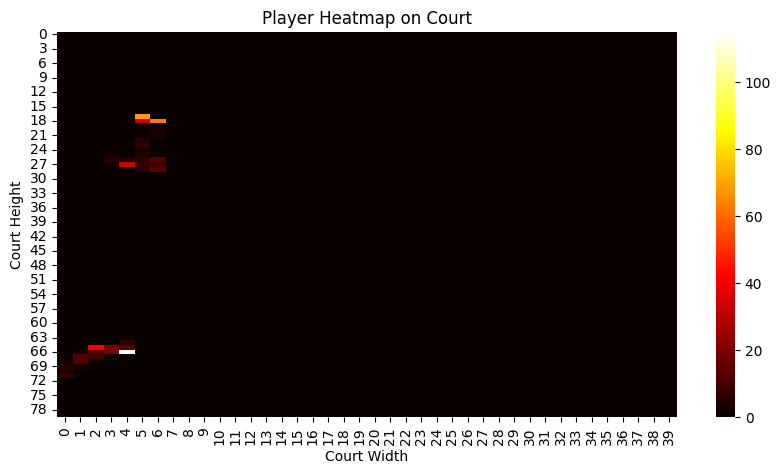

In [17]:
# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap, cmap="hot", cbar=True)
plt.title("Player Heatmap on Court")
plt.xlabel("Court Width")
plt.ylabel("Court Height")
plt.show()